# **CAP5150 project - Phish Hook**


The main goal is to expand the results of Basker et. al., inquiring about the results of the best perfoming model, XGBoost, in different datasets.

## **1. Creating the 4th dataset:**



Datasets 2 and 3 are imported from the web, as mentioned in the paper. However, due to early results, i wanted to create a 4th dataset with the same methods as the original work by Basker. Thus i followed the steps below to create a new dataet.

In [20]:
import requests

url = 'http://data.phishtank.com/data/online-valid.csv'
response = requests.get(url)

if response.status_code == 200:
    with open('online-valid.csv', 'wb') as f:
        f.write(response.content) 
    print("File saved as 'online-valid.csv'")
else:
    print(f"Failed to retrieve file, status code {response.status_code}")



File saved as 'online-valid.csv'


As with the original authors, i wanted to end up with a balanced set of 5000 phishing and 5000 non-phishing URLS. So i randomly extracted 5000 entries fom the phishtank csv files.

In [21]:
import pandas as pd

df = pd.read_csv('online-valid.csv')

df_sample = df.sample(n=5000, random_state=42)

# We only require the URL collumn 
df_sample = df_sample[['url']]

# Save the result to a new CSV file
df_sample.to_csv('random_sample_5000_urls.csv', index=False)

print(df_sample.head())


                                                     url
4869    https://currently-att-11-18-2024.weeblysite.com/
59525                https://review-id-10002755.web.app/
44428  https://docs.google.com/presentation/d/e/2PACX...
62921                    https://swisspost-zoll.web.app/
34788                             https://qrco.de/bfHrPM


In [4]:
df_sample.shape

(5000, 1)

I use the same benign dataset as the original paper, provided by University of New Brunswick, saved as "dataset-Benign-full.csv".  I also draw 5000 random elements from that dataset. I then add a 1 label to the phshing URLs and a 0 label to the non-phishing before merging them into a 10000 URL dataset called "dataset4.csv"

In [22]:
import pandas as pd

df_sample = pd.read_csv('random_sample_5000_urls.csv')
df_sample['label'] = 1  # Add a column 'label' full of 1s that represent phishing

benign_df = pd.read_csv('dataset-Benign-full.csv')
benign_sample = benign_df.sample(n=5000, random_state=42)

benign_sample['label'] = 0  # Add a column 'label' full of 0s that represent valid

# merge
merged_df = pd.concat([df_sample[['url', 'label']], benign_sample[['url', 'label']]])

# shuffle
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)

merged_df = merged_df.rename(columns={'url': 'URL', 'label': 'Label'})

merged_df.to_csv('merged_phishing_benign.csv', index=False)

print(merged_df.shape)
print(merged_df.head())


(10000, 2)
                                                 URL  Label
0  http://babal.net/books/view/29/%D9%84%D8%A7-%D...      0
1                               https://roness.date/      1
2                            https://t.co/JJS5z0dva2      1
3                            https://l.ead.me/bfFinz      1
4                              https://mxdihill.top/      1


I have label my original random sample as "dataset4.csv" but for the sake of reproducing results. the code above creates a new random file under "merged_phishing_benign.csv".

## **2. Running the model on the Test dataset**

Some of these datasets are extensive and take while to run, even with the optimizations. Thus i prepared a brief 25 entry dataset for quick reproducing of results. You can run the python script "featuresTest.py" to obtain the "extractedTest.csv" file.

In [9]:
!python3 featuresTest.py

Extracting features: 100%|██████████████████████| 25/25 [00:03<00:00,  6.49it/s]
Feature extraction complete. The extracted features are saved in 'extractedTest.csv'.


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data0 = pd.read_csv("extractedTest.csv")
data0.head()

,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,label
0,http://dbs.vote-friend.com/sg?ref=anything,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1
1,https://www.reynoldstransfer.com/versa-lift-fo...,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,0
2,https://www.halisupportservice.com/Login.php,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1
3,https://www.signets.com.br/wp-includes/wlwmani...,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0
4,https://docs.google.com/document/d/e/2PACX-1vT...,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,1


In [11]:
data0.shape


(25, 18)

In [12]:
data0.columns

Index(['Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth',
       'Redirection', 'https_Domain', 'TinyURL', 'Prefix/Suffix', 'DNS_Record',
       'Web_Traffic', 'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over',
       'Right_Click', 'Web_Forwards', 'label'],
      dtype='object')

Because the original trained model had an older version of XGBoost, I had to open it and repackage it. 
## you dont have to run this one

In [ ]:
import xgboost as xgb
import pickle

# original
with open("XGBoostClassifier.pickle.dat", "rb") as file:
    xgb_model = pickle.load(file)

# repackaged
xgb_model.save_model("XGBoostClassifier.json")

Check if we reproduce the results of the original paper. The authors separate the dataset into 2,000-training and 8,000-testing. Due to shuffling and randomizer, we apply it to the the whole 10,000 set.  

In [14]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import accuracy_score

xgb_model = xgb.Booster()
xgb_model.load_model("XGBoostClassifier.json")

data = pd.read_csv("Extracted Datasets/extracted1.csv")
target_column = "label"  

X = data.drop(columns=[target_column, "Domain"])
y = data[target_column]

dtest = xgb.DMatrix(X)
y_pred = xgb_model.predict(dtest)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]  

accuracy = accuracy_score(y, y_pred)
print(f"XGBoost: Accuracy on test data: {accuracy:.3f}")


XGBoost: Accuracy on test data: 0.865


This accuracy reflects the orignial results of the paper, which finds .867 accuracy for trainning and .858 for testing. Now we apply the model to our test file.

In [15]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import accuracy_score

xgb_model = xgb.Booster()
xgb_model.load_model("XGBoostClassifier.json")

data = pd.read_csv("extractedTest.csv")
target_column = "label" 

X = data.drop(columns=[target_column, "Domain"])
y = data[target_column]

dtest = xgb.DMatrix(X)
y_pred = xgb_model.predict(dtest)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

accuracy = accuracy_score(y, y_pred)
print(f"XGBoost: Accuracy on test data: {accuracy:.3f}")



XGBoost: Accuracy on test data: 0.400


## **3. Running the actual databases.**

These results can be reproduced by running the "features2.py ... features4.py" scripts. 

In [17]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

accuracy_dict = {}

xgb_model = xgb.Booster()
xgb_model.load_model("XGBoostClassifier.json")

dataset_files = ["Extracted Datasets/extracted1.csv", "Extracted Datasets/extracted2.csv", "Extracted Datasets/extracted3.csv", "Extracted Datasets/extracted4.csv"]

for file in dataset_files:
    data = pd.read_csv(file)
    
    X = data.drop(columns=["Domain","label"])
    y = data["label"]
    
    dtest = xgb.DMatrix(X)
    
    y_pred = xgb_model.predict(dtest)
    y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]
    
    accuracy = accuracy_score(y, y_pred)
    accuracy_dict[file] = accuracy  

accuracy_df = pd.DataFrame(list(accuracy_dict.items()), columns=["Dataset", "Accuracy"])
print(accuracy_df)


                             Dataset  Accuracy
0  Extracted Datasets/extracted1.csv  0.865200
1  Extracted Datasets/extracted2.csv  0.496000
2  Extracted Datasets/extracted3.csv  0.505774
3  Extracted Datasets/extracted4.csv  0.514200


/var/folders/kt/kfdg97mx6kqcdxk4gys9fd580000gn/T/ipykernel_88150/649886284.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Dataset", y="Accuracy", data=accuracy_df, palette="viridis")


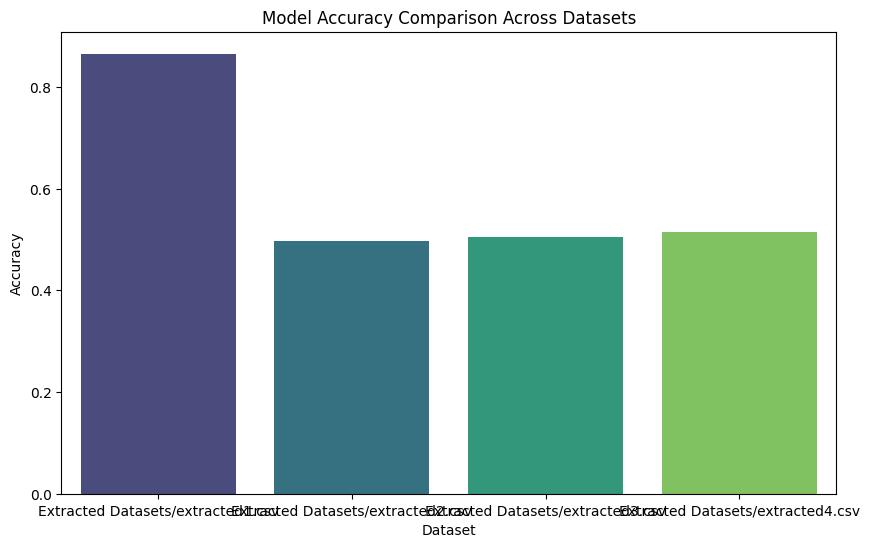

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Dataset", y="Accuracy", data=accuracy_df, palette="viridis")
plt.title("Model Accuracy Comparison Across Datasets")
plt.ylabel("Accuracy")
plt.xlabel("Dataset")


plt.savefig("accuracy_comparison.pdf", format="pdf")

plt.show()


          Feature  Importance
3       URL_Depth      1073.0
9      Domain_Age       302.0
10     Domain_End       240.0
8     Web_Traffic       126.0
11         iFrame       117.0
5         TinyURL       113.0
7      DNS_Record       106.0
13   Web_Forwards       103.0
1         Have_At        77.0
4     Redirection        77.0
12     Mouse_Over        77.0
6   Prefix/Suffix        68.0
2      URL_Length        19.0
0         Have_IP         9.0


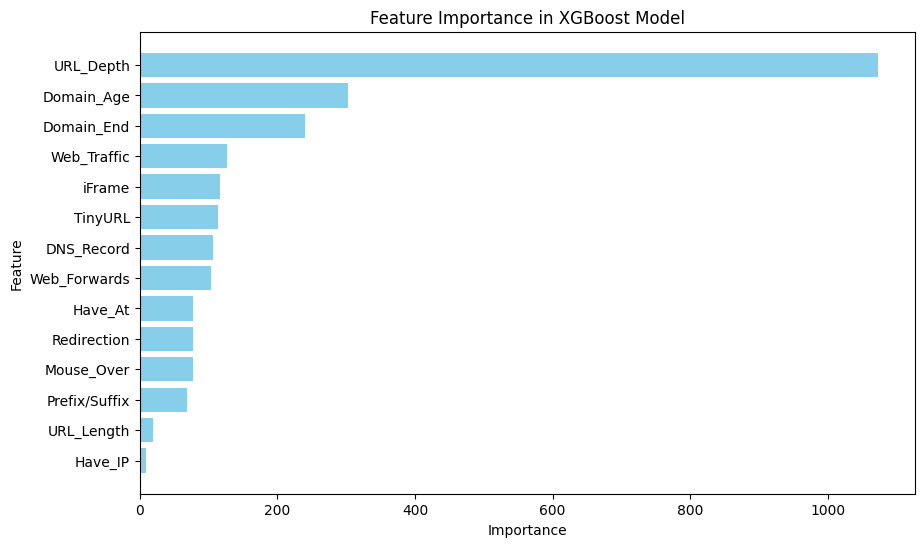

In [28]:
feature_names = [
    'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth', 'Redirection',
    'https_Domain', 'TinyURL', 'Prefix/Suffix', 'DNS_Record', 'Web_Traffic', 
    'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over', 'Right_Click', 'Web_Forwards'
]

# Get feature importance directly
importance = xgb_model.get_score(importance_type="weight")

# Create DataFrame for feature importance
importance_df = pd.DataFrame({
    "Feature": importance.keys(),
    "Importance": importance.values()
})

# Sort by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Display the feature importances
print(importance_df)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in XGBoost Model")
plt.gca().invert_yaxis()  # Invert y-axis for descending order

plt.savefig("feature_important.pdf", format="pdf")

plt.show()


Now we perform features correlation analysis to find out more about why the results have not performed as well.


Correlation Matrix for extracted1.csv:
                Have_IP   Have_At  URL_Length  URL_Depth  Redirection  \
Have_IP        1.000000 -0.011308   -0.076021  -0.030466    -0.008700   
Have_At       -0.011308  1.000000    0.067844   0.029944    -0.000297   
URL_Length    -0.076021  0.067844    1.000000   0.439378     0.038482   
URL_Depth     -0.030466  0.029944    0.439378   1.000000    -0.040189   
Redirection   -0.008700 -0.000297    0.038482  -0.040189     1.000000   
https_Domain  -0.001052 -0.002151    0.007656  -0.000478    -0.001655   
TinyURL       -0.023430  0.067122   -0.005318   0.010980     0.026634   
Prefix/Suffix -0.023841  0.018369   -0.146102  -0.114919    -0.025581   
DNS_Record    -0.011425  0.025073   -0.019508  -0.086073    -0.027654   
Web_Traffic    0.024279 -0.017002    0.063717   0.075315     0.018784   
Domain_Age     0.047349 -0.017072    0.071029  -0.070101     0.012581   
Domain_End     0.018799  0.001651    0.028755  -0.061798     0.025758   
iFrame     

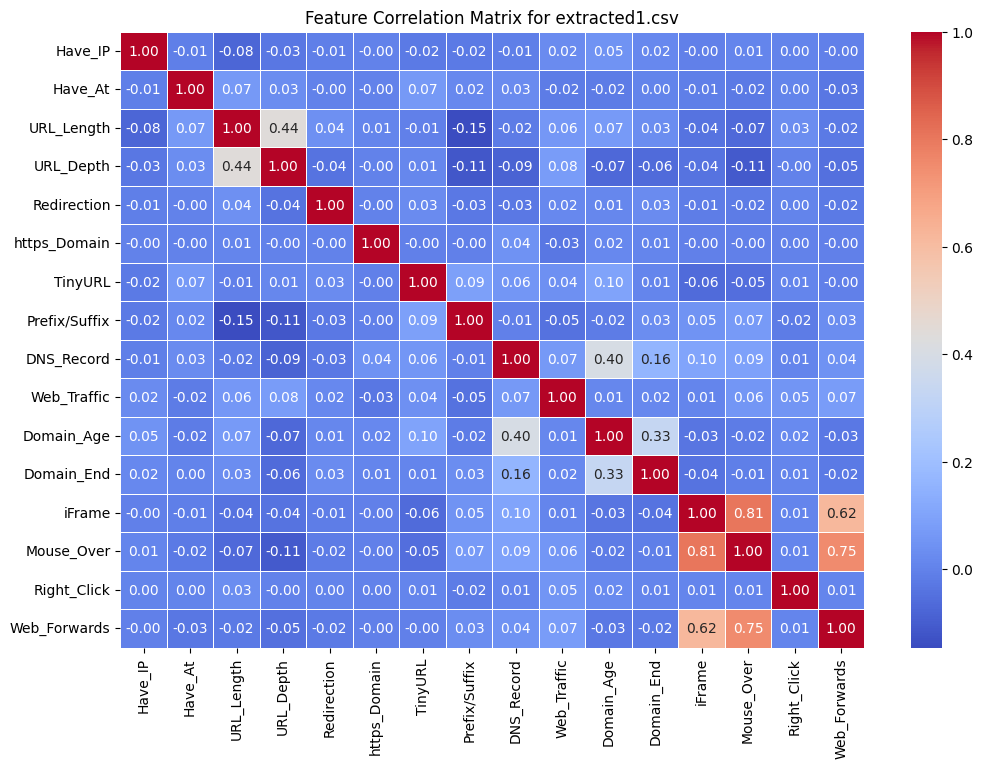


Correlation Matrix for extracted2.csv:
               Have_IP   Have_At  URL_Length  URL_Depth  Redirection  \
Have_IP            NaN       NaN         NaN        NaN          NaN   
Have_At            NaN  1.000000    0.181356   0.085533     0.176923   
URL_Length         NaN  0.181356    1.000000   0.507030     0.102249   
URL_Depth          NaN  0.085533    0.507030   1.000000     0.020676   
Redirection        NaN  0.176923    0.102249   0.020676     1.000000   
https_Domain       NaN -0.006509   -0.019750  -0.045356    -0.003927   
TinyURL            NaN  0.048502    0.050020   0.025654     0.008364   
Prefix/Suffix      NaN -0.024156    0.134788  -0.063149    -0.001004   
DNS_Record         NaN       NaN         NaN        NaN          NaN   
Web_Traffic        NaN       NaN         NaN        NaN          NaN   
Domain_Age         NaN       NaN         NaN        NaN          NaN   
Domain_End         NaN       NaN         NaN        NaN          NaN   
iFrame             NaN  

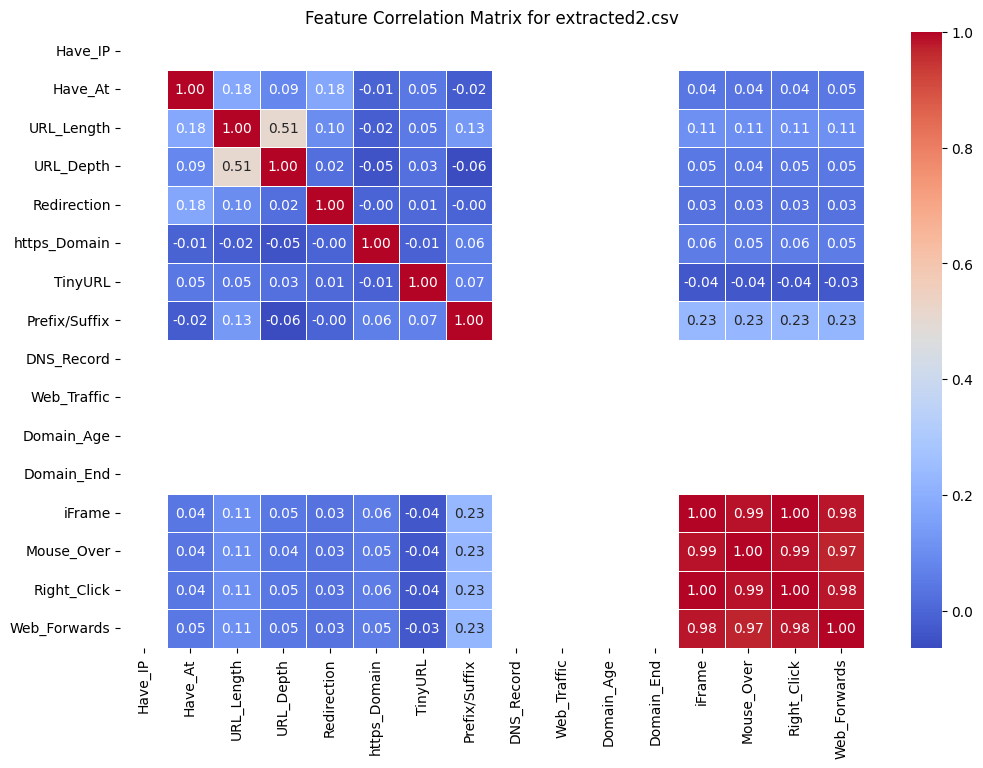


Correlation Matrix for extracted3.csv:
               Have_IP   Have_At  URL_Length  URL_Depth  Redirection  \
Have_IP            NaN       NaN         NaN        NaN          NaN   
Have_At            NaN  1.000000    0.150473   0.084409     0.062792   
URL_Length         NaN  0.150473    1.000000   0.578159     0.058723   
URL_Depth          NaN  0.084409    0.578159   1.000000    -0.007023   
Redirection        NaN  0.062792    0.058723  -0.007023     1.000000   
https_Domain       NaN  0.111439    0.042857   0.003270    -0.002946   
TinyURL            NaN  0.000134   -0.020136  -0.011106    -0.005166   
Prefix/Suffix      NaN -0.012402    0.090620  -0.047710    -0.025445   
DNS_Record         NaN       NaN         NaN        NaN          NaN   
Web_Traffic        NaN       NaN         NaN        NaN          NaN   
Domain_Age         NaN       NaN         NaN        NaN          NaN   
Domain_End         NaN       NaN         NaN        NaN          NaN   
iFrame             NaN  

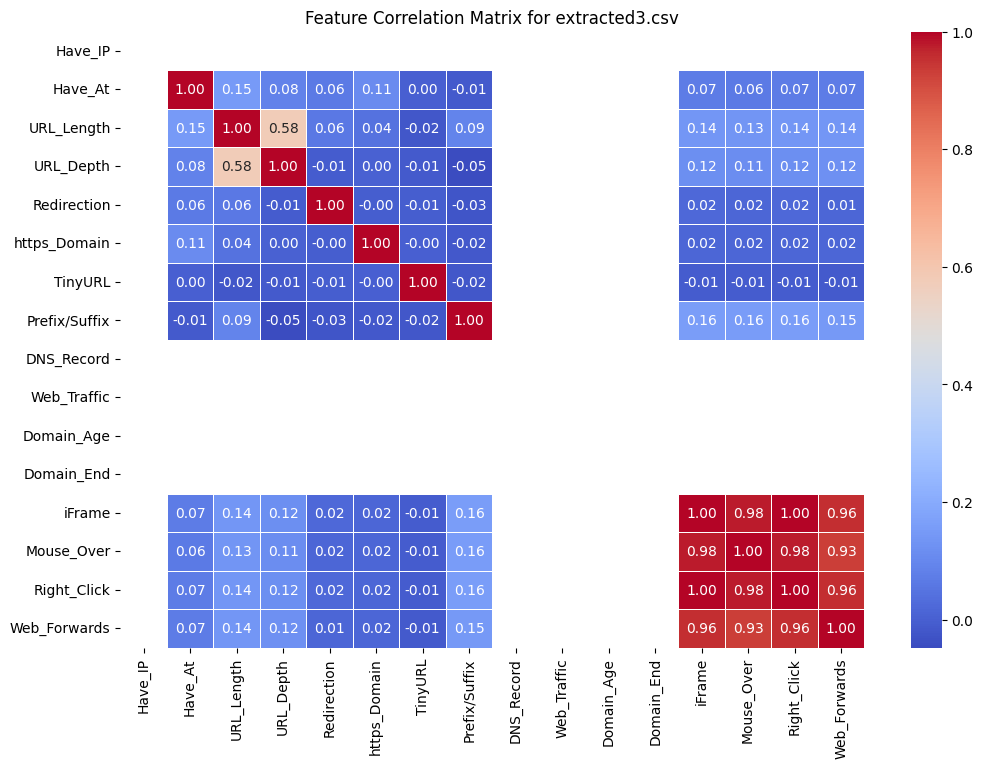


Correlation Matrix for extracted4.csv:
               Have_IP   Have_At  URL_Length  URL_Depth  Redirection  \
Have_IP            NaN       NaN         NaN        NaN          NaN   
Have_At            NaN  1.000000    0.030048   0.003474    -0.009748   
URL_Length         NaN  0.030048    1.000000   0.599370     0.073795   
URL_Depth          NaN  0.003474    0.599370   1.000000    -0.015127   
Redirection        NaN -0.009748    0.073795  -0.015127     1.000000   
https_Domain       NaN -0.000840    0.007455  -0.010825    -0.001161   
TinyURL            NaN  0.038771   -0.089138  -0.017838     0.030173   
Prefix/Suffix      NaN  0.013513   -0.283114  -0.342074    -0.045083   
DNS_Record         NaN       NaN         NaN        NaN          NaN   
Web_Traffic        NaN       NaN         NaN        NaN          NaN   
Domain_Age         NaN       NaN         NaN        NaN          NaN   
Domain_End         NaN       NaN         NaN        NaN          NaN   
iFrame             NaN -

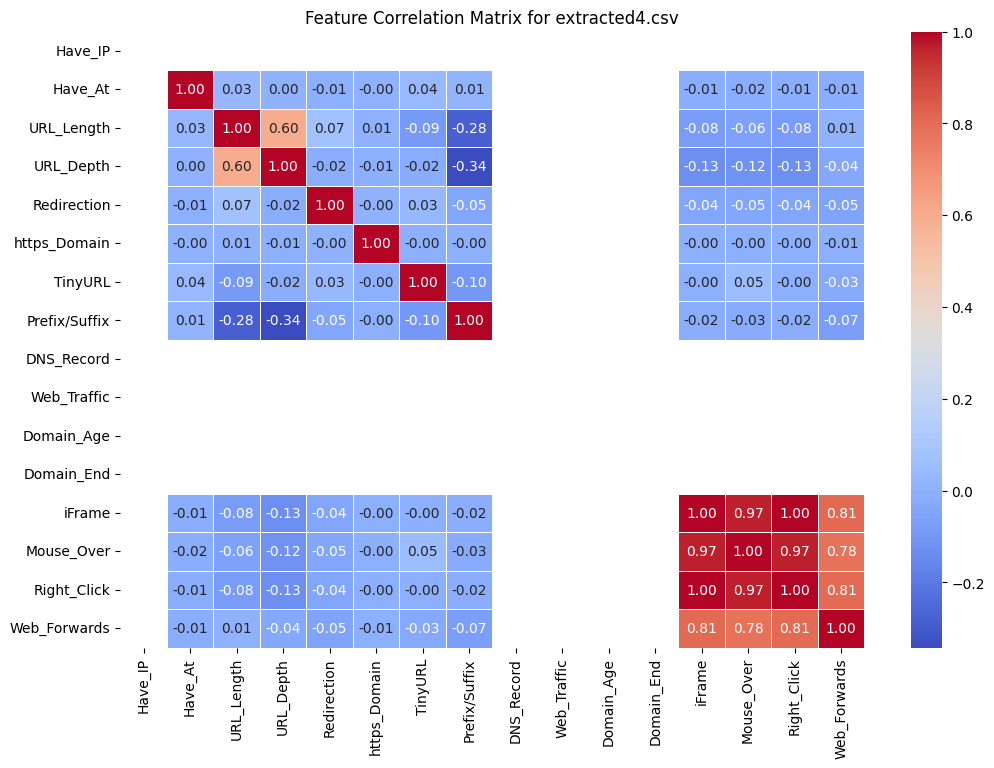

In [19]:
files = {
    "extracted1.csv": pd.read_csv("Extracted Datasets/extracted1.csv"),
    "extracted2.csv": pd.read_csv("Extracted Datasets/extracted2.csv"),
    "extracted3.csv": pd.read_csv("Extracted Datasets/extracted3.csv"),
    "extracted4.csv": pd.read_csv("Extracted Datasets/extracted4.csv")
}

columns_dict = {file: data.columns.tolist() for file, data in files.items()}

for file, data in files.items():
    # Drop the label column and non-numeric columns
    X = data.drop(columns=["label", "Domain"])  # Adjust column names as needed
    correlation_matrix = X.corr()

    print(f"\nCorrelation Matrix for {file}:")
    print(correlation_matrix)
    
    # Plot the correlation matrix for each dataset
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(f"Feature Correlation Matrix for {file}")
    plt.show()